In [1]:
import ciw
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import pandas as pd
import pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-whitegrid')

In [2]:
ciw.__version__

'3.0.0'

# Hybrid Simulation (SD+DES)

## System Dynamics Component

In [3]:
class SD():
    """
    A class to hold the SD component.
    """
    # changed the parameters to match the SD model
    def __init__(
        self,
        adult_population,
        paediatric_population,
        backlog_propotion,
        ageing_rate,
        fertility_rate,
        #birth_rate,
        adult_condition_rate,
        paediatric_condition_rate,
        adult_death_rate,
        paediatric_death_rate,
        gatekeeping_rate,
        **kwargs,
    ):
        """
        Initialised the parameters for the SD component
        """
        w = backlog_propotion
        N_a = adult_population
        N_p = paediatric_population
        self.P = [[N_p * (1 - w)], [N_p * w], [N_a * (1 - w)], [N_a * w]] # stocks here are defined as P 
        self.ageing_rate = ageing_rate
        self.fertility_rate = fertility_rate
        self.birth_rate = (
        (adult_death_rate + ((adult_death_rate * paediatric_death_rate) / ageing_rate))
        ) / fertility_rate
        #self.birth_rate = birth_rate
        self.adult_condition_rate = adult_condition_rate
        self.paediatric_condition_rate = paediatric_condition_rate
        self.adult_death_rate = adult_death_rate
        self.paediatric_death_rate = paediatric_death_rate
        self.gatekeeping = gatekeeping_rate
        self.time = np.array([0]) # time domain
    
    def differential_equations(self, y, time_domain,):
        """
        Defines the differential equations that define the system.
        Returns the value of the derivatives for each B_i.
        """
        P_n, P_c, A_n, A_c = y
        N = P_n + P_c + A_n + A_c
        
        dP_ndt = (
            (self.birth_rate * self.fertility_rate * (A_n + A_c)) 
            - (P_n * (self.ageing_rate + self.paediatric_condition_rate))
            - (self.paediatric_death_rate * P_n)
        )
        dP_cdt = (
            (self.paediatric_condition_rate * P_n)
            - (P_c * self.ageing_rate)
            - (self.paediatric_death_rate * P_c)
        )

        dA_ndt = (
            (self.ageing_rate * P_n)
            - (self.adult_condition_rate * A_n)
            - (A_n * self.adult_death_rate)
        )
        dA_cdt = (
            (self.ageing_rate * P_c)
            + (self.adult_condition_rate * A_n)
            - (A_c * self.adult_death_rate)
        )

        return dP_ndt, dP_cdt, dA_ndt, dA_cdt
    
    def solve(self, t, **kwargs):
        """
        Solves the differential equations from
        the time of the pervious event to time t.
        """
        leaving_class = kwargs['leaving_class']

        # Solve the SD over the relevant time domain
        y = (self.P[0][-1], self.P[1][-1], self.P[2][-1], self.P[3][-1])
        relevant = (self.time_domain <= t) & (self.time_domain >= self.time[-1]) # relevant time domain
        times_between_events = np.concatenate((np.array([self.time[-1]]), 
                                               self.time_domain[relevant], 
                                               np.array([t])), 
                                               axis=None) # times between events including end points
        results = odeint(self.differential_equations, y, times_between_events,) # solve the SD

        P0, P1, P2, P3 = results.T # unpack the results
        self.P[0] = np.append(self.P[0], P0) 
        self.P[1] = np.append(self.P[1], P1)
        self.P[2] = np.append(self.P[2], P2)
        self.P[3] = np.append(self.P[3], P3)
        
        # Add and subtract the current error from it's pool
        if leaving_class == 'Paediatrics':
            leaving_index = 1 # work out the index of the stock that objects are leaving
            receiving_index = 0 # work out the index of the stock that objects are entering
            #number_to_remove = max(self.P[leaving_index][-1], 1) ##################### This line here causes the stock to deplete ##################### should gatekeeping parameter go here?
            self.P[leaving_index][-1] -= 1 # remove the objects from the stock they're leaving
            self.P[receiving_index][-1] += 1 # add the objects to the stock they're entering
        if leaving_class == 'Adults':
            leaving_index = 3 # work out the index of the stock that objects are leaving
            receiving_index = 2 # work out the index of the stock that objects are entering
            #number_to_remove = max(self.P[leaving_index][-1], 1) ##################### This line here causes the stock to deplete ##################### should gatekeeping parameter go here?
            self.P[leaving_index][-1] -= 1 # remove the objects from the stock they're leaving
            self.P[receiving_index][-1] += 1 # add the objects to the stock they're entering

        # Update the times over which we've already solved the SD
        self.time = np.append(self.time, times_between_events) # update the time domain

In [4]:
23000/365

63.013698630136986

## Discrete Event Component

In [5]:
class HybridSimulation(ciw.Simulation):
    """
    A Simulation object that includes the SD component as an
    attribute and communicates with it at the relevant points
    of the simulation.
    """
    def __init__(self, network, **kwargs):
        """
        Initialises the HybridSimulation object.
        Creates and attaches the SD component.
        """
        self.SD = SD(**kwargs)
        super().__init__(network=network, node_class=HybridNode)
        
    def simulate_until_max_time(self, max_simulation_time, n_steps, progress_bar):
        """
        Runs the simulation until the max_simulation time.
        Creates the time domain, runs the simulation, and solves
        the SD component one last time.
        """
        self.SD.time_domain = np.linspace(0, max_simulation_time, n_steps) # create the time domain, n steps between 0 and max_simulation_time
        super().simulate_until_max_time(max_simulation_time, progress_bar=progress_bar) # run the simulation
        self.SD.solve(t=max_simulation_time, leaving_class=None) # solve the SD one last time from the last event to the max_simulation_time

In [6]:
class HybridNode(ciw.Node):
    """
    A Node object that communicates with the SD component at
    the relevant points of the simulation.
    """
    def release(self, next_individual, next_node):
        """
        Releases the current individual at the end of their service.
        Solves the SD component.
        """
        leaving_class = next_individual.customer_class # class of the individual currently leaving
        super().release(next_individual, next_node) # release the individual
        self.simulation.SD.solve(t=self.get_now(), leaving_class=leaving_class) # solve the SD 

In [7]:
def get_arrival_distribution(i):
    """
    Creates a distribution class and returns and instance of that class.
    Creates a distribution class for arrivals from P_i.
    Solves the SD component before sampling.
    """
    class SolveSDArrivals(ciw.dists.Distribution):            
        def sample(self, t=None, ind=None):
            if t > 0: 
                self.simulation.SD.solve(t, leaving_class=None) 
            number_of_this_class_in_the_queue = len([ind for ind in self.simulation.nodes[1].all_individuals if ind.customer_class == i]) # number of individuals of this class in the DES
            if i == 'Paediatrics':
                number_individuals_potentially_presenting = self.simulation.SD.P[1][-1] - number_of_this_class_in_the_queue # subtract number from DES from number in SD stock
            if i == 'Adults':   
                number_individuals_potentially_presenting = self.simulation.SD.P[3][-1] - number_of_this_class_in_the_queue # subtract number from DES from number in SD stock
            if number_individuals_potentially_presenting <= 0 or self.simulation.SD.gatekeeping <= 0: 
                return float('inf') # if there are no individuals in the SD stock or the gatekeeping rate is 0, return inf
            rate = (1 - self.simulation.SD.gatekeeping) * number_individuals_potentially_presenting
            # what if everyone is waiting? Take max of the above and 0
            return ciw.dists.Exponential(rate).sample() # sample DES arrival distribution based on the rate parameter
    return SolveSDArrivals()

In [8]:
no_clinics_per_day = 63 # number of outpatient clinics carried out per day

In [9]:
N = ciw.create_network(
    arrival_distributions={'Paediatrics': [get_arrival_distribution('Paediatrics')],
                           'Adults': [get_arrival_distribution('Adults')]},
    service_distributions={'Paediatrics': [ciw.dists.Deterministic(value=1/365)],
                           'Adults': [ciw.dists.Deterministic(value=1/365)]},
    number_of_servers=[no_clinics_per_day], # set number of servers at each node
)

In [10]:
# Q = HybridSimulation(
#     network=N,
#     adult_population=390745,
#     paediatric_population=101301,
#     backlog_propotion=0.05,
#     ageing_rate=(1/18),
#     fertility_rate=0.8,
#     adult_condition_rate=0.01,
#     paediatric_condition_rate=0.01,
#     adult_death_rate=(1/85),
#     paediatric_death_rate=(1/85),
#     gatekeeping_rate = 2
# )

In [11]:
ciw.seed(1)

Q = HybridSimulation(
    network=N,
    adult_population=390745,
    paediatric_population=101301,
    backlog_propotion=0.1,
    ageing_rate=1/18,
    fertility_rate=0.8,
    adult_condition_rate=0.05,
    paediatric_condition_rate=0.05,
    adult_death_rate=1/85,
    paediatric_death_rate=1/85,
    gatekeeping_rate = 0.01
)

In [12]:
Q.simulate_until_max_time(
	max_simulation_time = 1,
    n_steps = 100*365*1,
    progress_bar = True
)

  1%|          | 0.008281777304475303/1 [00:00<00:12, 12.11s/it]

100%|██████████| 1.0/1 [01:35<00:00, 95.22s/it]                 


In [13]:
Q.nodes[-1].all_individuals

[Individual 1,
 Individual 2,
 Individual 3,
 Individual 4,
 Individual 5,
 Individual 6,
 Individual 7,
 Individual 8,
 Individual 9,
 Individual 10,
 Individual 11,
 Individual 12,
 Individual 13,
 Individual 14,
 Individual 15,
 Individual 16,
 Individual 17,
 Individual 18,
 Individual 19,
 Individual 20,
 Individual 21,
 Individual 22,
 Individual 23,
 Individual 24,
 Individual 25,
 Individual 26,
 Individual 27,
 Individual 28,
 Individual 29,
 Individual 30,
 Individual 31,
 Individual 32,
 Individual 33,
 Individual 34,
 Individual 35,
 Individual 36,
 Individual 37,
 Individual 38,
 Individual 39,
 Individual 40,
 Individual 41,
 Individual 42,
 Individual 43,
 Individual 44,
 Individual 45,
 Individual 46,
 Individual 47,
 Individual 48,
 Individual 49,
 Individual 50,
 Individual 51,
 Individual 52,
 Individual 53,
 Individual 54,
 Individual 55,
 Individual 56,
 Individual 57,
 Individual 58,
 Individual 59,
 Individual 60,
 Individual 61,
 Individual 62,
 Individual 63,
 

In [14]:
recs = Q.get_all_records()
pd.DataFrame(recs)

,id_number,customer_class,original_customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,server_id,record_type
0,1,Adults,Adults,1,0.000004,0.000000,0.000004,0.00274,0.002743,0.0,0.002743,-1,0,146,1,service
1,2,Adults,Adults,1,0.000041,0.000000,0.000041,0.00274,0.002781,0.0,0.002781,-1,1,146,2,service
2,3,Adults,Adults,1,0.000049,0.000000,0.000049,0.00274,0.002788,0.0,0.002788,-1,2,148,3,service
3,4,Adults,Adults,1,0.000066,0.000000,0.000066,0.00274,0.002806,0.0,0.002806,-1,3,149,4,service
4,5,Adults,Adults,1,0.000082,0.000000,0.000082,0.00274,0.002821,0.0,0.002821,-1,4,149,5,service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22927,22928,Adults,Adults,1,0.538002,0.457674,0.995676,0.00274,0.998416,0.0,0.998416,-1,10591,15752,59,service
22928,22929,Paediatrics,Paediatrics,1,0.538019,0.457662,0.995681,0.00274,0.998421,0.0,0.998421,-1,10591,15752,60,service
22929,22930,Paediatrics,Paediatrics,1,0.538039,0.457650,0.995689,0.00274,0.998429,0.0,0.998429,-1,10592,15751,61,service
22930,22931,Adults,Adults,1,0.538051,0.457651,0.995702,0.00274,0.998442,0.0,0.998442,-1,10593,15750,62,service


Text(0, 0.5, 'Population')

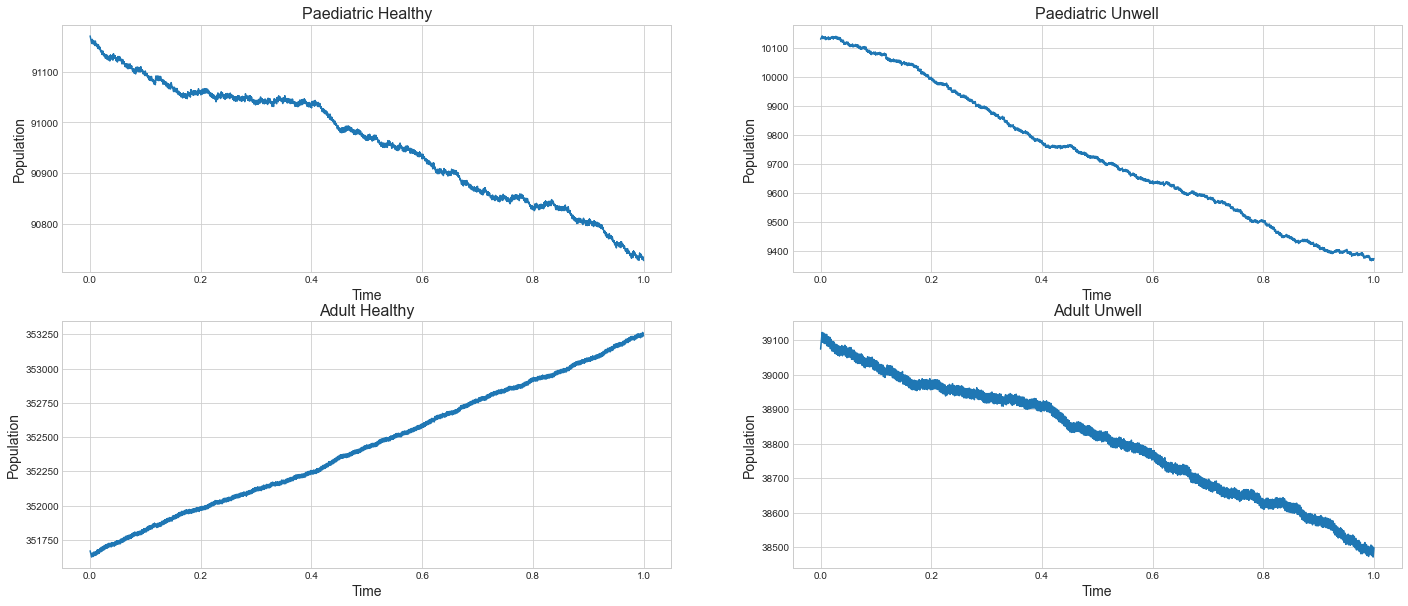

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(24, 10))
axs[0, 0].plot(Q.SD.time, Q.SD.P[0], label="$P_{n}$")
axs[0, 0].set_title('Paediatric Healthy', fontsize=16)
axs[0, 0].set_xlabel('Time', fontsize=14)
axs[0, 0].set_ylabel('Population', fontsize=14)
axs[0, 1].plot(Q.SD.time, Q.SD.P[1], label="$P_{c}$")
axs[0, 1].set_title('Paediatric Unwell', fontsize=16)
axs[0, 1].set_xlabel('Time', fontsize=14)
axs[0, 1].set_ylabel('Population', fontsize=14)
axs[1, 0].plot(Q.SD.time, Q.SD.P[2], label="$A_{n}$")
axs[1, 0].set_title('Adult Healthy', fontsize=16)
axs[1, 0].set_xlabel('Time', fontsize=14)
axs[1, 0].set_ylabel('Population', fontsize=14)
axs[1, 1].plot(Q.SD.time, Q.SD.P[3], label="$A_{c}$")
axs[1, 1].set_title('Adult Unwell', fontsize=16)
axs[1, 1].set_xlabel('Time', fontsize=14)
axs[1, 1].set_ylabel('Population', fontsize=14)
#plt.savefig('SD_populations2.png')

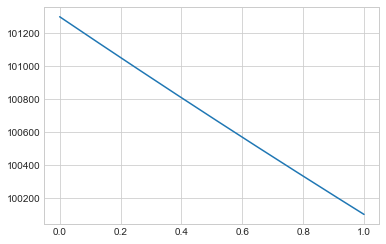

In [17]:
fig, ax = plt.subplots(1)
ax.plot(Q.SD.time, Q.SD.P[0]+Q.SD.P[1], label="$P_{n}$")

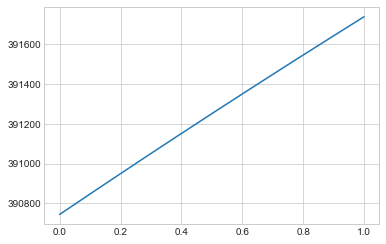

In [18]:
fig, ax = plt.subplots(1)
ax.plot(Q.SD.time, Q.SD.P[2]+Q.SD.P[3], label="$P_{n}$")